In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error


/psi/home/ammann_r/.local/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [13]:
test_datafile = directory +'/aerosol_data/raw_data_bimodal/pre_log_ts-0.2_wl-532_sc-None/test_dataset.hdf5'

In [14]:
model_name = 'forward_model'

In [15]:
model_dir = directory +'/aerosol_results/new_dataset/forward_asha_inverted_log_P11_P12/models/'

In [16]:
plot_dir = directory +'/aerosol_results/new_dataset/forward_asha_inverted_log_P11_P12/plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Load the model and the data

In [17]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')
#surr = KerasSurrogate.load(model_dir, model_name)

In [18]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [19]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [29]:
dvar_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -21.753173   -21.858864   -21.956736   -22.044334   -22.120742   
1       -20.460594   -20.523678   -20.584374   -20.640857   -20.692446   
2       -21.678921   -21.773631   -21.861357   -21.939817   -22.007618   
3       -20.522450   -20.680206   -20.828471   -20.961295   -21.075351   
4       -20.408601   -20.544032   -20.665186   -20.770137   -20.858902   
...            ...          ...          ...          ...          ...   
19995   -20.813858   -20.878938   -20.942206   -21.001764   -21.056266   
19996   -20.693125   -20.800460   -20.902739   -20.996467   -21.079284   
19997   -21.694462   -21.804254   -21.908515   -22.003580   -22.087094   
19998   -21.152066   -21.221998   -21.285385   -21.341435   -21.390239   
19999   -20.619627   -20.747313   -20.877607   -21.005921   -21.128381   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -22.186657    -22.243320    -22.292090    -22.334656    -22.372433   
1        -20.739294    -20.782018    -20.821154    -20.857586    -20.891495   
2        -22.066041    -22.116988    -22.161275    -22.200054    -22.235259   
3        -21.171586    -21.252086    -21.318887    -21.374293    -21.423196   
4        -20.933506    -20.996690    -21.050715    -21.097770    -21.139964   
...             ...           ...           ...           ...           ...   
19995    -21.105786    -21.150777    -21.191399    -21.228573    -21.262251   
19996    -21.151375    -21.213358    -21.266236    -21.312846    -21.353964   
19997    -22.159465    -22.221923    -22.275568    -22.321813    -22.362905   
19998    -21.433091    -21.471440    -21.506294    -21.538897    -21.569588   
19999    -21.242863    -21.347932    -21.442572    -21.525625    -21.599639   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...       0.006772       0.002546      -0.001376      -0.004922   
1      ...      -0.029796      -0.029468      -0.028732      -0.027577   
2      ...       0.005092       0.000266      -0.004461      -0.009066   
3      ...       0.015654       0.012356       0.008130       0.003045   
4      ...      -0.000168      -0.002598      -0.004869      -0.006964   
...    ...            ...            ...            ...            ...   
19995  ...      -0.031203      -0.031223      -0.030669      -0.029538   
19996  ...      -0.048463      -0.056318      -0.064492      -0.072258   
19997  ...       0.007703       0.002614      -0.002191      -0.006635   
19998  ...       0.008904       0.005102       0.001525      -0.001799   
19999  ...      -0.096203      -0.099991      -0.102620      -0.103660   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.007973      -0.010377      -0.011974      -0.012623   
1          -0.025974      -0.023892      -0.021322      -0.018297   
2          -0.013378      -0.017081      -0.019750      -0.020941   
3          -0.002550      -0.008047      -0.012659      -0.015589   
4          -0.008798      -0.010243      -0.011146      -0.011367   
...              ...            ...            ...            ...   
19995      -0.027824      -0.025529      -0.022675      -0.019335   
19996      -0.078761      -0.083022      -0.084001      -0.080783   
19997      -0.010539      -0.013649      -0.015679      -0.016384   
19998      -0.004777      -0.007254      -0.009044      -0.009969   
19999      -0.102590      -0.098872      -0.092042      -0.081950   

       P12_0.532_174  P12_0.532_175  
0          -0.012238      -0.010835  
1          -0.014919      -0.011366  
2          -0.020317      -0.017806  
3          -0.016251      -0.014539  
4          -0.010814      -0.009479  
...              ...            ...  
19995      -0.015645      -0.011815  
19996      -0.072835      -0.060412  
19997      -0.015637      -0.013520  
19998      -0.009911      -0.008868  
19999      -0.068895      -0.0537

In [30]:
qoi_test

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse      V_tot  \
0          1.480761        1.552695      0.058397        0.005880   9.722911   
1          1.575458        1.497135      0.057269        0.014687  23.003213   
2          1.391997        1.496126      0.092570        0.008067  13.200783   
3          1.487489        1.465119      0.027702        0.001546  20.455700   
4          1.588219        1.528239      0.085664        0.010191  22.523999   
...             ...             ...           ...             ...        ...   
19995      1.482469        1.484318      0.008467        0.015698  23.310734   
19996      1.574798        1.587827      0.081343        0.006950  18.564973   
19997      1.436615        1.517872      0.126130        0.010458  12.082657   
19998      1.435685        1.523314      0.077233        0.011144  17.560679   
19999      1.485760        1.523242      0.081208        0.002117  20.155443   

            FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0      0.845728  0.130066    1.123332  1.420850    1.487589  
1      0.854241  0.157977    1.037686  1.485561    1.434949  
2      0.889476  0.140440    1.201885  1.534167    1.455457  
3      0.665190  0.145012    1.272089  1.514938    1.413690  
4      0.710390  0.151952    1.297953  1.493747    1.486553  
...         ...       ...         ...       ...         ...  
19995  0.878549  0.130477    0.993841  1.532007    1.475255  
19996  0.746804  0.148863    1.138562  1.471771    1.446150  
19997  0.865969  0.127825    1.149722  1.567017    1.412949  
19998  0.906785  0.158628    1.213001  1.455003    1.443433  
19999  0.653789  0.132495    0.948064  1.385637    1.475193  

[20000 rows x 10 columns]

In [31]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse      V_tot  \
0          1.480761        1.552695      0.058397        0.005880   9.722911   
1          1.575458        1.497135      0.057269        0.014687  23.003213   
2          1.391997        1.496126      0.092570        0.008067  13.200783   
3          1.487489        1.465119      0.027702        0.001546  20.455700   
4          1.588219        1.528239      0.085664        0.010191  22.523999   
...             ...             ...           ...             ...        ...   
19995      1.482469        1.484318      0.008467        0.015698  23.310734   
19996      1.574798        1.587827      0.081343        0.006950  18.564973   
19997      1.436615        1.517872      0.126130        0.010458  12.082657   
19998      1.435685        1.523314      0.077233        0.011144  17.560679   
19999      1.485760        1.523242      0.081208        0.002117  20.155443   

            FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0      0.845728  0.130066    1.123332  1.420850    1.487589  
1      0.854241  0.157977    1.037686  1.485561    1.434949  
2      0.889476  0.140440    1.201885  1.534167    1.455457  
3      0.665190  0.145012    1.272089  1.514938    1.413690  
4      0.710390  0.151952    1.297953  1.493747    1.486553  
...         ...       ...         ...       ...         ...  
19995  0.878549  0.130477    0.993841  1.532007    1.475255  
19996  0.746804  0.148863    1.138562  1.471771    1.446150  
19997  0.865969  0.127825    1.149722  1.567017    1.412949  
19998  0.906785  0.158628    1.213001  1.455003    1.443433  
19999  0.653789  0.132495    0.948064  1.385637    1.475193  

[20000 rows x 10 columns]

In [32]:
dvar_test = dvar_test.reset_index(drop = True)
dvar_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -21.753173   -21.858864   -21.956736   -22.044334   -22.120742   
1       -20.460594   -20.523678   -20.584374   -20.640857   -20.692446   
2       -21.678921   -21.773631   -21.861357   -21.939817   -22.007618   
3       -20.522450   -20.680206   -20.828471   -20.961295   -21.075351   
4       -20.408601   -20.544032   -20.665186   -20.770137   -20.858902   
...            ...          ...          ...          ...          ...   
19995   -20.813858   -20.878938   -20.942206   -21.001764   -21.056266   
19996   -20.693125   -20.800460   -20.902739   -20.996467   -21.079284   
19997   -21.694462   -21.804254   -21.908515   -22.003580   -22.087094   
19998   -21.152066   -21.221998   -21.285385   -21.341435   -21.390239   
19999   -20.619627   -20.747313   -20.877607   -21.005921   -21.128381   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -22.186657    -22.243320    -22.292090    -22.334656    -22.372433   
1        -20.739294    -20.782018    -20.821154    -20.857586    -20.891495   
2        -22.066041    -22.116988    -22.161275    -22.200054    -22.235259   
3        -21.171586    -21.252086    -21.318887    -21.374293    -21.423196   
4        -20.933506    -20.996690    -21.050715    -21.097770    -21.139964   
...             ...           ...           ...           ...           ...   
19995    -21.105786    -21.150777    -21.191399    -21.228573    -21.262251   
19996    -21.151375    -21.213358    -21.266236    -21.312846    -21.353964   
19997    -22.159465    -22.221923    -22.275568    -22.321813    -22.362905   
19998    -21.433091    -21.471440    -21.506294    -21.538897    -21.569588   
19999    -21.242863    -21.347932    -21.442572    -21.525625    -21.599639   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...       0.006772       0.002546      -0.001376      -0.004922   
1      ...      -0.029796      -0.029468      -0.028732      -0.027577   
2      ...       0.005092       0.000266      -0.004461      -0.009066   
3      ...       0.015654       0.012356       0.008130       0.003045   
4      ...      -0.000168      -0.002598      -0.004869      -0.006964   
...    ...            ...            ...            ...            ...   
19995  ...      -0.031203      -0.031223      -0.030669      -0.029538   
19996  ...      -0.048463      -0.056318      -0.064492      -0.072258   
19997  ...       0.007703       0.002614      -0.002191      -0.006635   
19998  ...       0.008904       0.005102       0.001525      -0.001799   
19999  ...      -0.096203      -0.099991      -0.102620      -0.103660   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.007973      -0.010377      -0.011974      -0.012623   
1          -0.025974      -0.023892      -0.021322      -0.018297   
2          -0.013378      -0.017081      -0.019750      -0.020941   
3          -0.002550      -0.008047      -0.012659      -0.015589   
4          -0.008798      -0.010243      -0.011146      -0.011367   
...              ...            ...            ...            ...   
19995      -0.027824      -0.025529      -0.022675      -0.019335   
19996      -0.078761      -0.083022      -0.084001      -0.080783   
19997      -0.010539      -0.013649      -0.015679      -0.016384   
19998      -0.004777      -0.007254      -0.009044      -0.009969   
19999      -0.102590      -0.098872      -0.092042      -0.081950   

       P12_0.532_174  P12_0.532_175  
0          -0.012238      -0.010835  
1          -0.014919      -0.011366  
2          -0.020317      -0.017806  
3          -0.016251      -0.014539  
4          -0.010814      -0.009479  
...              ...            ...  
19995      -0.015645      -0.011815  
19996      -0.072835      -0.060412  
19997      -0.015637      -0.013520  
19998      -0.009911      -0.008868  
19999      -0.068895      -0.0537

In [33]:
dvar_test.columns

Index(['P11_0.532_5', 'P11_0.532_6', 'P11_0.532_7', 'P11_0.532_8',
       'P11_0.532_9', 'P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12',
       'P11_0.532_13', 'P11_0.532_14',
       ...
       'P12_0.532_166', 'P12_0.532_167', 'P12_0.532_168', 'P12_0.532_169',
       'P12_0.532_170', 'P12_0.532_171', 'P12_0.532_172', 'P12_0.532_173',
       'P12_0.532_174', 'P12_0.532_175'],
      dtype='object', length=320)

In [45]:
qoi_columns = qoi_test.columns
qoi_columns

Index(['n_532nm_fine', 'n_532nm_coarse', 'k_532nm_fine', 'k_532nm_coarse',
       'V_tot', 'FMF', 'CMR_fine', 'CMR_coarse', 'GSD_fine', 'GSD_coarse'],
      dtype='object')

# Predict

In [35]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [36]:
qoi_pred

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse      V_tot  \
0          1.485100        1.551236      0.061616        0.005415   9.268239   
1          1.577810        1.491938      0.058361        0.013474  22.950213   
2          1.396486        1.493681      0.097700        0.007976  13.353203   
3          1.488332        1.463197      0.033425        0.001757  20.888684   
4          1.587210        1.524004      0.087387        0.009539  22.259794   
...             ...             ...           ...             ...        ...   
19995      1.479707        1.478073      0.009825        0.014585  23.146824   
19996      1.576999        1.586047      0.083669        0.006941  18.887467   
19997      1.436392        1.520754      0.128957        0.010671  12.460819   
19998      1.436460        1.519373      0.075669        0.011471  17.711136   
19999      1.491766        1.522360      0.082164        0.001546  20.182990   

            FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0      0.851938  0.130140    1.129217  1.422727    1.486735  
1      0.864665  0.159350    1.056001  1.490175    1.439455  
2      0.891414  0.140672    1.202778  1.534526    1.452106  
3      0.668857  0.145272    1.287971  1.521972    1.412963  
4      0.720193  0.153124    1.294401  1.492207    1.484988  
...         ...       ...         ...       ...         ...  
19995  0.888361  0.131529    1.004936  1.534442    1.473297  
19996  0.756694  0.149386    1.154331  1.473364    1.449623  
19997  0.874738  0.128394    1.162500  1.571710    1.417247  
19998  0.913688  0.159637    1.233825  1.455866    1.444320  
19999  0.665328  0.132850    0.948181  1.388490    1.471111  

[20000 rows x 10 columns]

# Calculate metrics

In [37]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

## R2 


Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

#metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric = RSquaredSeparated()
r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T
print('Forward model: ','R2_min = ', min(r2_adj.min()),';  R2_max = ', max(r2_adj.max()))
r2_adj

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small

In [38]:
abs_error = np.abs(qoi_pred - qoi_test)
abs_error

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse     V_tot  \
0          0.004339        0.001459      0.003219        0.000465  0.454672   
1          0.002352        0.005197      0.001092        0.001213  0.053000   
2          0.004489        0.002445      0.005130        0.000091  0.152420   
3          0.000843        0.001923      0.005724        0.000211  0.432984   
4          0.001009        0.004236      0.001723        0.000651  0.264206   
...             ...             ...           ...             ...       ...   
19995      0.002762        0.006245      0.001358        0.001113  0.163909   
19996      0.002200        0.001780      0.002326        0.000009  0.322494   
19997      0.000223        0.002881      0.002827        0.000213  0.378162   
19998      0.000775        0.003941      0.001564        0.000326  0.150457   
19999      0.006006        0.000881      0.000956        0.000571  0.027548   

            FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0      0.006210  0.000074    0.005885  0.001877    0.000853  
1      0.010424  0.001373    0.018315  0.004614    0.004506  
2      0.001938  0.000232    0.000893  0.000359    0.003351  
3      0.003667  0.000260    0.015883  0.007035    0.000727  
4      0.009803  0.001172    0.003553  0.001540    0.001564  
...         ...       ...         ...       ...         ...  
19995  0.009812  0.001052    0.011095  0.002435    0.001958  
19996  0.009890  0.000523    0.015769  0.001594    0.003473  
19997  0.008769  0.000569    0.012778  0.004693    0.004298  
19998  0.006903  0.001009    0.020824  0.000864    0.000887  
19999  0.011539  0.000355    0.000116  0.002853    0.004082  

[20000 rows x 10 columns]

In [39]:
rel_error = abs_error / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse     V_tot  \
0          0.293052        0.093960      5.512461        7.908772  4.676292   
1          0.149284        0.347120      1.907465        8.261262  0.230401   
2          0.322481        0.163414      5.541430        1.130071  1.154629   
3          0.056656        0.131220     20.661529       13.629190  2.116692   
4          0.063557        0.277157      2.011858        6.392411  1.172996   
...             ...             ...           ...             ...       ...   
19995      0.186337        0.420707     16.035322        7.088137  0.703149   
19996      0.139706        0.112096      2.860039        0.133881  1.737110   
19997      0.015511        0.189823      2.241618        2.039799  3.129793   
19998      0.053986        0.258713      2.024476        2.929176  0.856782   
19999      0.404231        0.057865      1.177626       26.964752  0.136676   

            FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0      0.734255  0.056603    0.523876  0.132108    0.057368  
1      1.220248  0.869041    1.764941  0.310615    0.314019  
2      0.217912  0.164968    0.074298  0.023395    0.230268  
3      0.551268  0.179246    1.248549  0.464353    0.051443  
4      1.379966  0.771378    0.273712  0.103091    0.105238  
...         ...       ...         ...       ...         ...  
19995  1.116823  0.806465    1.116403  0.158963    0.132722  
19996  1.324298  0.351007    1.385014  0.108278    0.240148  
19997  1.012646  0.444941    1.111414  0.299486    0.304159  
19998  0.761274  0.636296    1.716709  0.059372    0.061452  
19999  1.764962  0.268063    0.012257  0.205924    0.276714  

[20000 rows x 10 columns]

In [40]:
abs_error_table =  np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse  V_tot   FMF  \
50%          0.00            0.00          0.00             0.0   0.15  0.01   
75%          0.00            0.00          0.00             0.0   0.26  0.01   
90%          0.00            0.01          0.01             0.0   0.36  0.01   
95%          0.01            0.01          0.01             0.0   0.43  0.01   
99%          0.01            0.01          0.01             0.0   0.59  0.02   

     CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
50%       0.0        0.01      0.00        0.00  
75%       0.0        0.01      0.00        0.00  
90%       0.0        0.02      0.01        0.01  
95%       0.0        0.02      0.01        0.01  
99%       0.0        0.03      0.01        0.01

In [41]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse  V_tot   FMF  \
50%          0.12            0.14          5.09            4.25   0.95  0.82   
75%          0.22            0.23         10.48            8.75   1.58  1.16   
90%          0.33            0.33         23.89           19.50   2.26  1.52   
95%          0.41            0.41         46.31           38.02   2.74  1.79   
99%          0.64            0.61        295.47          199.86   4.02  2.46   

     CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
50%      0.35        0.62      0.17        0.17  
75%      0.54        1.03      0.30        0.30  
90%      0.72        1.52      0.43        0.46  
95%      0.84        1.93      0.51        0.61  
99%      1.13        2.96      0.72        1.01

In [43]:
# if P11 and P12 are used:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)
abs_error_table_P11 = abs_error_table[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_P11.max(axis = 1))
abs_error_table_P12 = abs_error_table[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_P12.max(axis = 1))
rel_error_table_P11 = rel_error_table[P11_532_columns]
print('Relative error P11')
print(rel_error_table_P11.max(axis = 1))
rel_error_table_P12 = rel_error_table[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_P12.max(axis = 1))


Absolute error P11
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Absolute error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error P11
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [46]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

n_532nm_fine MAE:  0.0022833648376122664 *** MAPE 0.0015679056882663264
n_532nm_coarse MAE:  0.0025841468998701613 *** MAPE 0.0016934346754303065
k_532nm_fine MAE:  0.0033106965148498773 *** MAPE 0.35601580342553113
k_532nm_coarse MAE:  0.00040419449796320135 *** MAPE 0.17415206512667278
V_tot MAE:  0.17985226570507415 *** MAPE 0.011302709989756752
FMF MAE:  0.006224840399027719 *** MAPE 0.008795311838505307
CMR_fine MAE:  0.0005589872183691198 *** MAPE 0.003849492804709504
CMR_coarse MAE:  0.00814002087442532 *** MAPE 0.00752316418104681
GSD_fine MAE:  0.003063087030765767 *** MAPE 0.0020782324378788024
GSD_coarse MAE:  0.0032185583029748473 *** MAPE 0.002226996573891737


In [47]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse     V_tot  \
MAE_qoi      0.002283        0.002584      0.003311        0.000404  0.179852   

              FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
MAE_qoi  0.006225  0.000559     0.00814  0.003063    0.003219

In [48]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.179852
dtype: float64

In [49]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.020964
dtype: float64

In [50]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse  \
MAPE_qoi      0.001568        0.001693      0.356016        0.174152   

             V_tot       FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
MAPE_qoi  0.011303  0.008795  0.003849    0.007523  0.002078    0.002227

In [51]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    0.356016
dtype: float64

In [52]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.056921
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 


In [53]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


n_532nm_fine RMSE:  0.0030650057276485642
n_532nm_coarse RMSE:  0.003312509020932795
k_532nm_fine RMSE:  0.004171999900071467
k_532nm_coarse RMSE:  0.0005384168635155003
V_tot RMSE:  0.22604932044261847
FMF RMSE:  0.00709957857225101
CMR_fine RMSE:  0.0006758898600871194
CMR_coarse RMSE:  0.010562746979656644
GSD_fine RMSE:  0.0039009666946925206
GSD_coarse RMSE:  0.004401687278648275


In [54]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [55]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean       std       min       25%       50%       75%       max
0   10.0  0.026378  0.070218  0.000538  0.003127  0.004036  0.006425  0.226049

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [56]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


n_532nm_fine *** 0.9985468816769041
n_532nm_coarse *** 0.9967173016245302
k_532nm_fine *** 0.9946887720969082
k_532nm_coarse *** 0.9890282691645412
V_tot *** 0.9974443128226296
FMF *** 0.9988048431472482
CMR_fine *** 0.9981068314403078
CMR_coarse *** 0.9958223841715437
GSD_fine *** 0.9961352778105778
GSD_coarse *** 0.9716303493807813


In [57]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

n_532nm_fine  n_532nm_coarse  k_532nm_fine  k_532nm_coarse     V_tot  \
0      0.998547        0.996717      0.994689        0.989028  0.997444   

        FMF  CMR_fine  CMR_coarse  GSD_fine  GSD_coarse  
0  0.998805  0.998107    0.995822  0.996135     0.97163

In [58]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std      min       25%       50%       75%       max
0   10.0  0.993693  0.008249  0.97163  0.994972  0.996426  0.997941  0.998805

# Save $\bar{R}^2$

In [59]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

# Plot

## Plot qoi

In [60]:
presentation_plot_index = [0,1000,2000,5000,6000] 

### Plot for Particle Radius Distribution

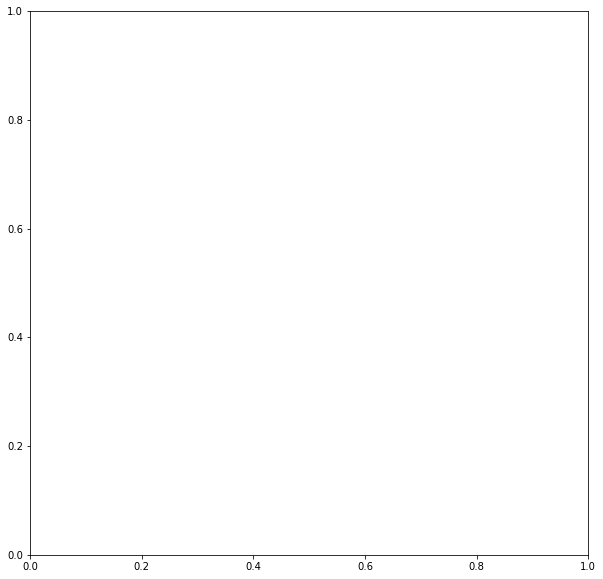

In [110]:
fig, ax = plt.subplots(figsize = (10,10));

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    

    mu1 = [qoi_pred.iloc[datapoint]['CMR_fine'], qoi_pred.iloc[datapoint]['CMR_coarse']]
    sigma1 = [qoi_pred.iloc[datapoint]['GSD_fine'], qoi_pred.iloc[datapoint]['GSD_coarse']]
    mu2 = [qoi_test.iloc[datapoint]['CMR_fine'], qoi_test.iloc[datapoint]['CMR_coarse']]
    sigma2 = [qoi_test.iloc[datapoint]['GSD_fine'], qoi_test.iloc[datapoint]['GSD_coarse']]
    Vtot1 = qoi_pred.iloc[datapoint]['V_tot']
    Vtot2 = qoi_test.iloc[datapoint]['V_tot']
    
    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)
    
    pdf1 = [(Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[0]))) * np.exp((-np.square((np.log(x) - np.log(mu1[0])))) / (2 * np.square(np.log(sigma1[0])))) +
             (Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[1]))) * np.exp((-np.square((np.log(x) - np.log(mu1[1])))) / (2 * np.square(np.log(sigma1[1])))) for x in x1]
    
            
    pdf2 = [(Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[0]))) * np.exp((-np.square((np.log(x) - np.log(mu2[0])))) / (2 * np.square(np.log(sigma2[0])))) +
             (Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[1]))) * np.exp((-np.square((np.log(x) - np.log(mu2[1])))) / (2 * np.square(np.log(sigma2[1])))) for x in x2]
    

    
    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


0
1000
2000
5000


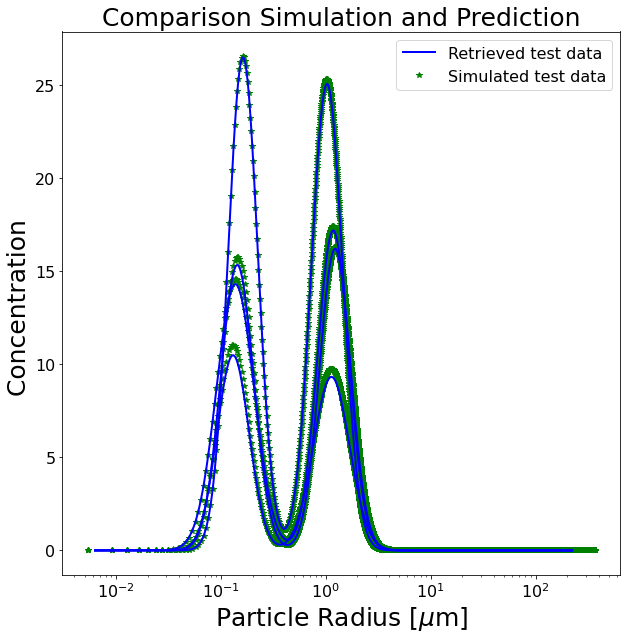

In [111]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2,label ='Retrieved test data', zorder = 5)
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, label = 'Simulated test data', zorder = 0)
    else:
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2 , zorder = 5)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, zorder = 0)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')

In [92]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)

In [69]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [70]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

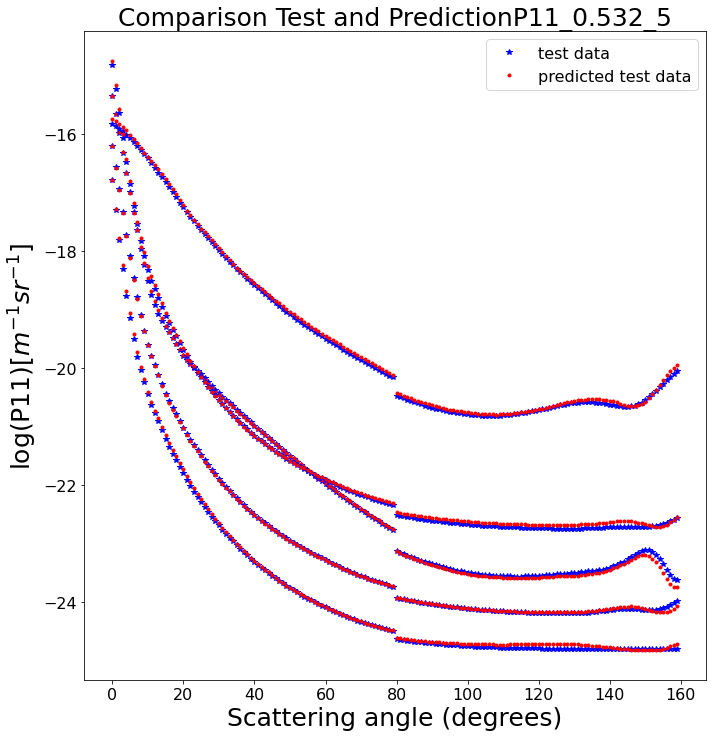

In [71]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

In [72]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

## correlation plots

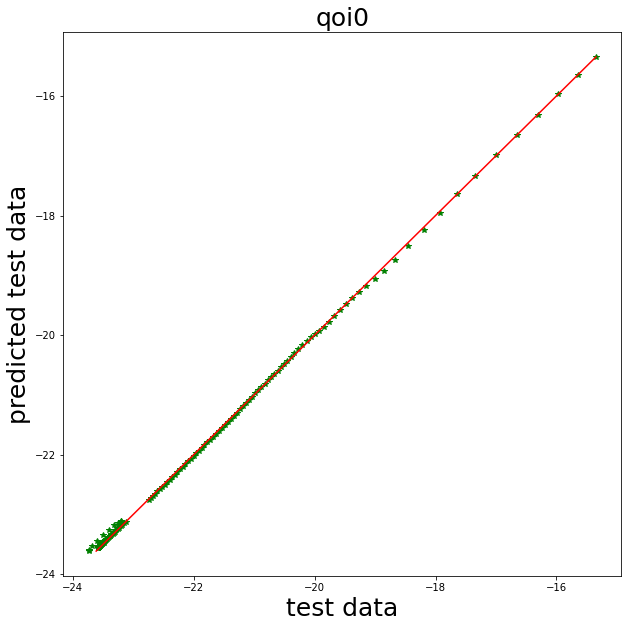

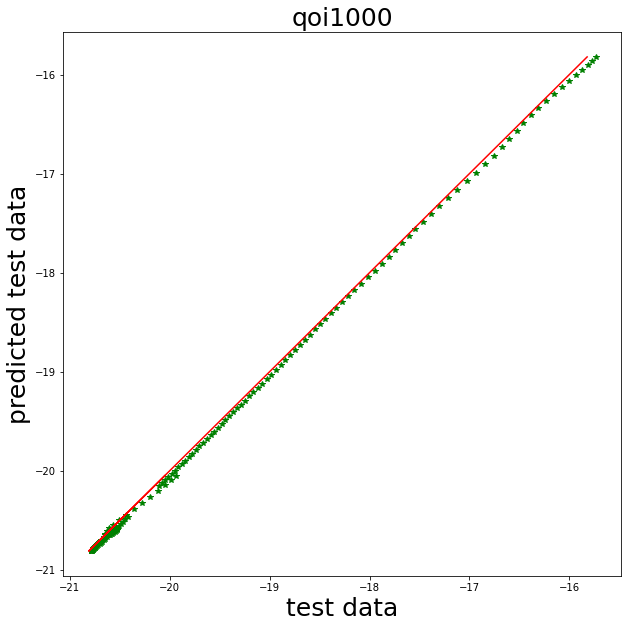

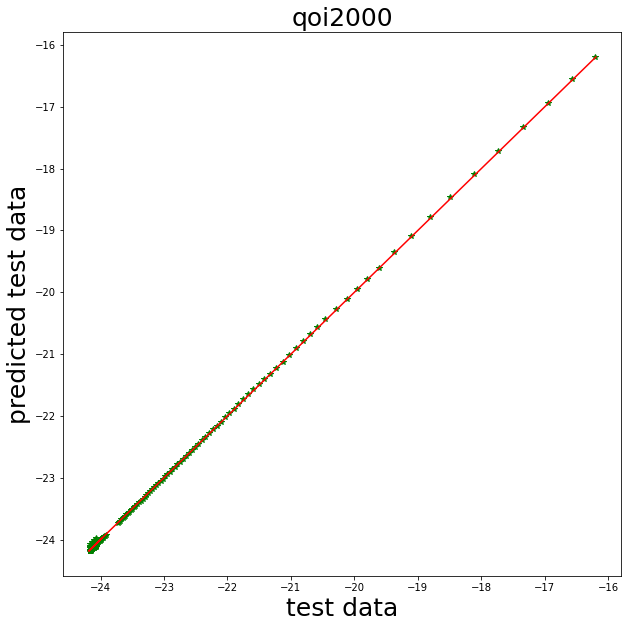

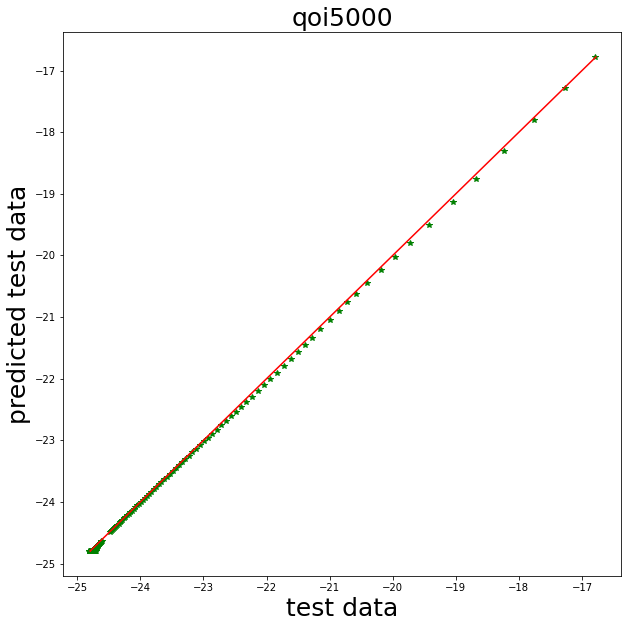

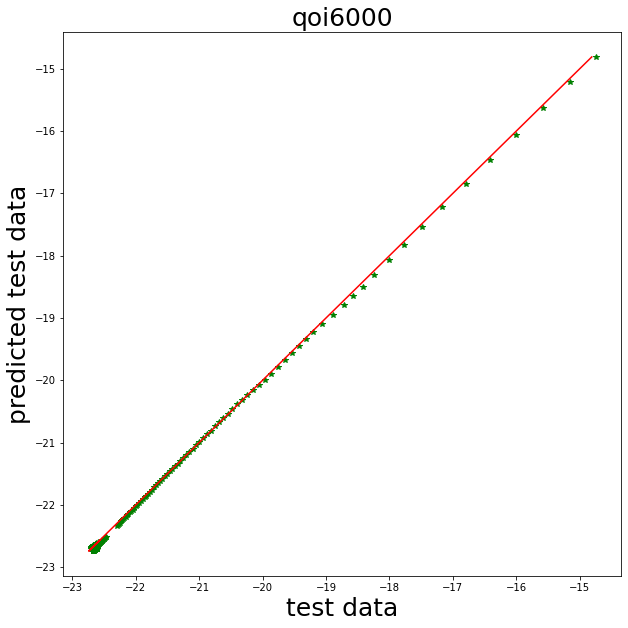

In [73]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

## Plot R2 

In [78]:
r2_adj

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0          1.0          1.0          1.0          1.0          1.0   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0           1.0           1.0           1.0           1.0           1.0  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0            1.0            1.0            1.0            1.0            1.0   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0            1.0            1.0            1.0            1.0            1.0  

[1 rows x 160 columns]

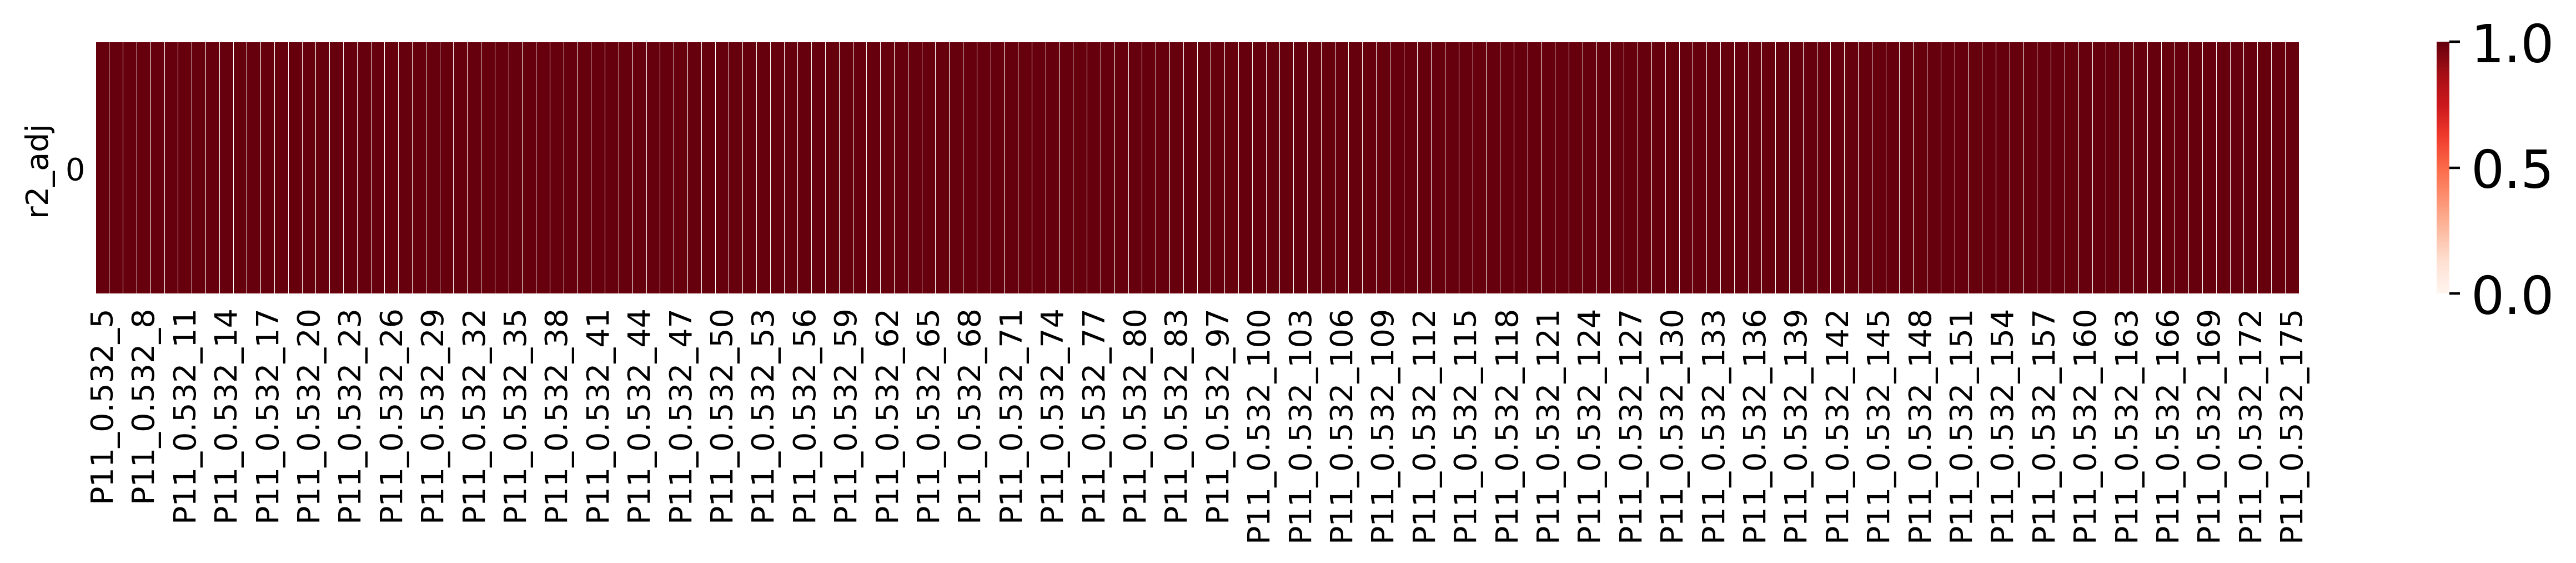

In [80]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()
ax.set_ylabel('r2_adj')
# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Plot Relative / Absolute Errors 

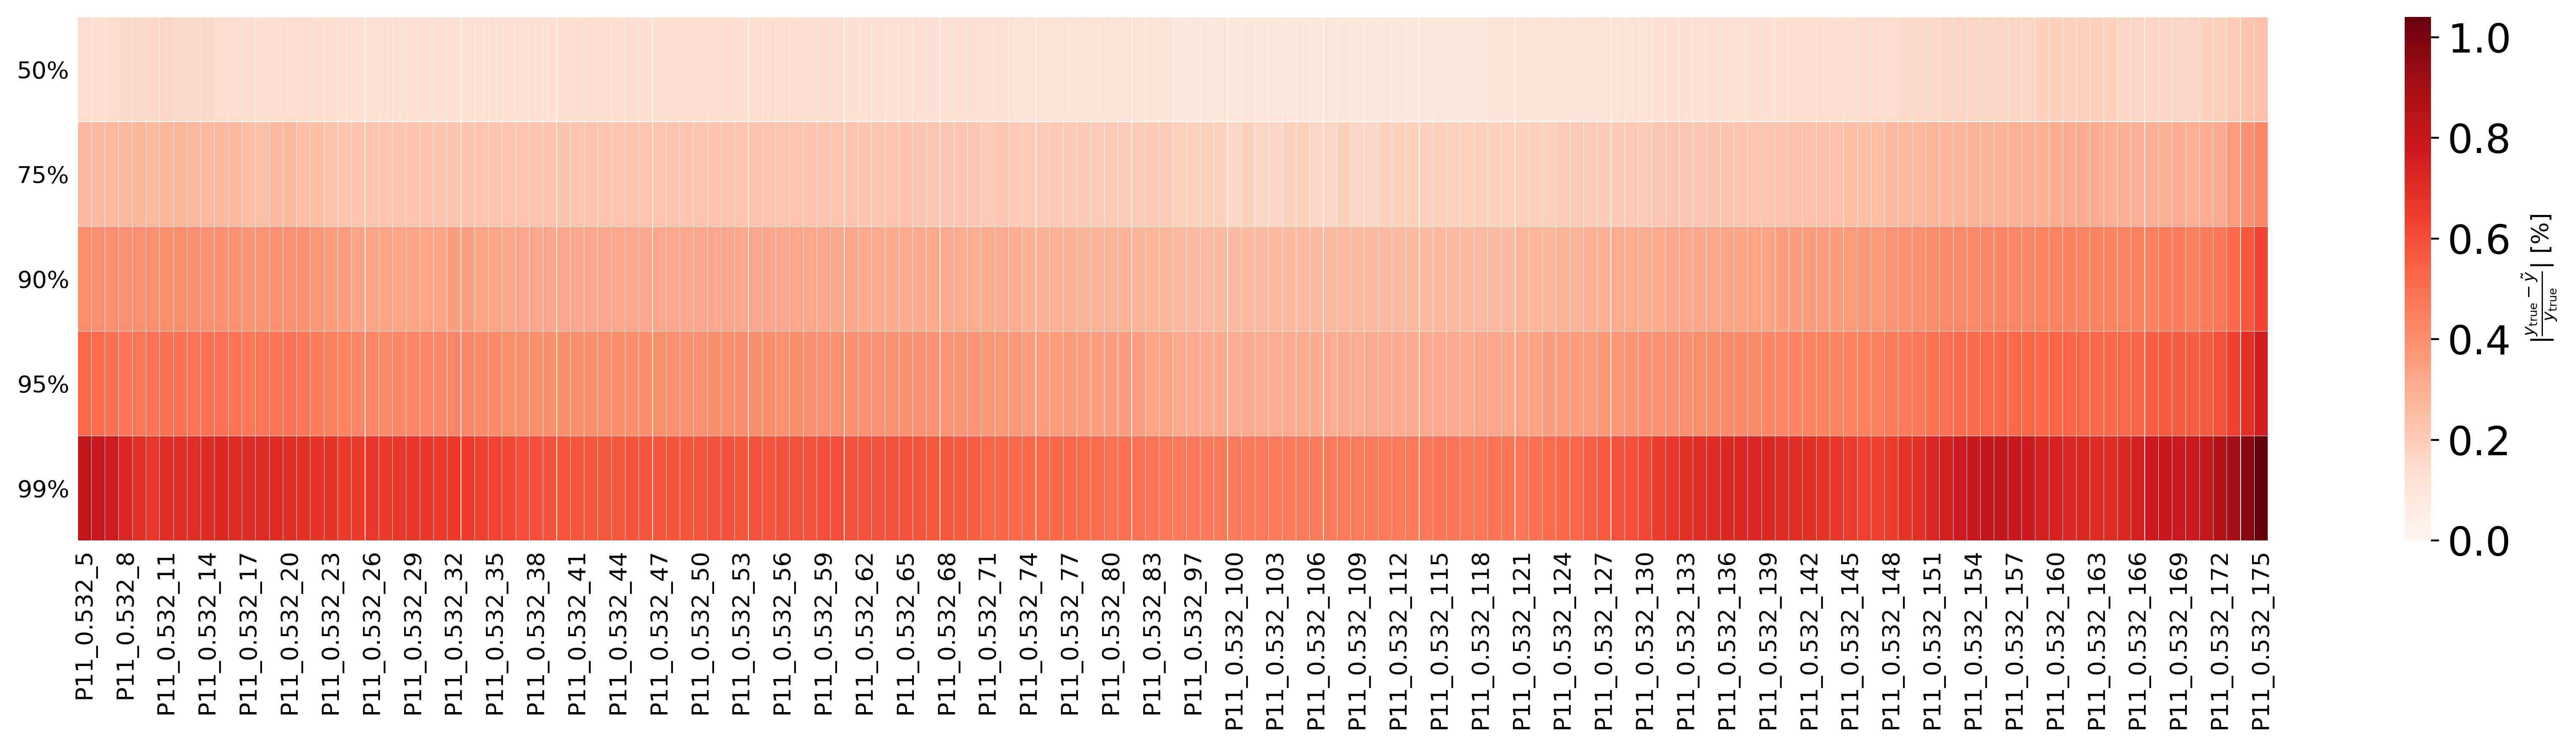

In [83]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_P11,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P11.jpg')

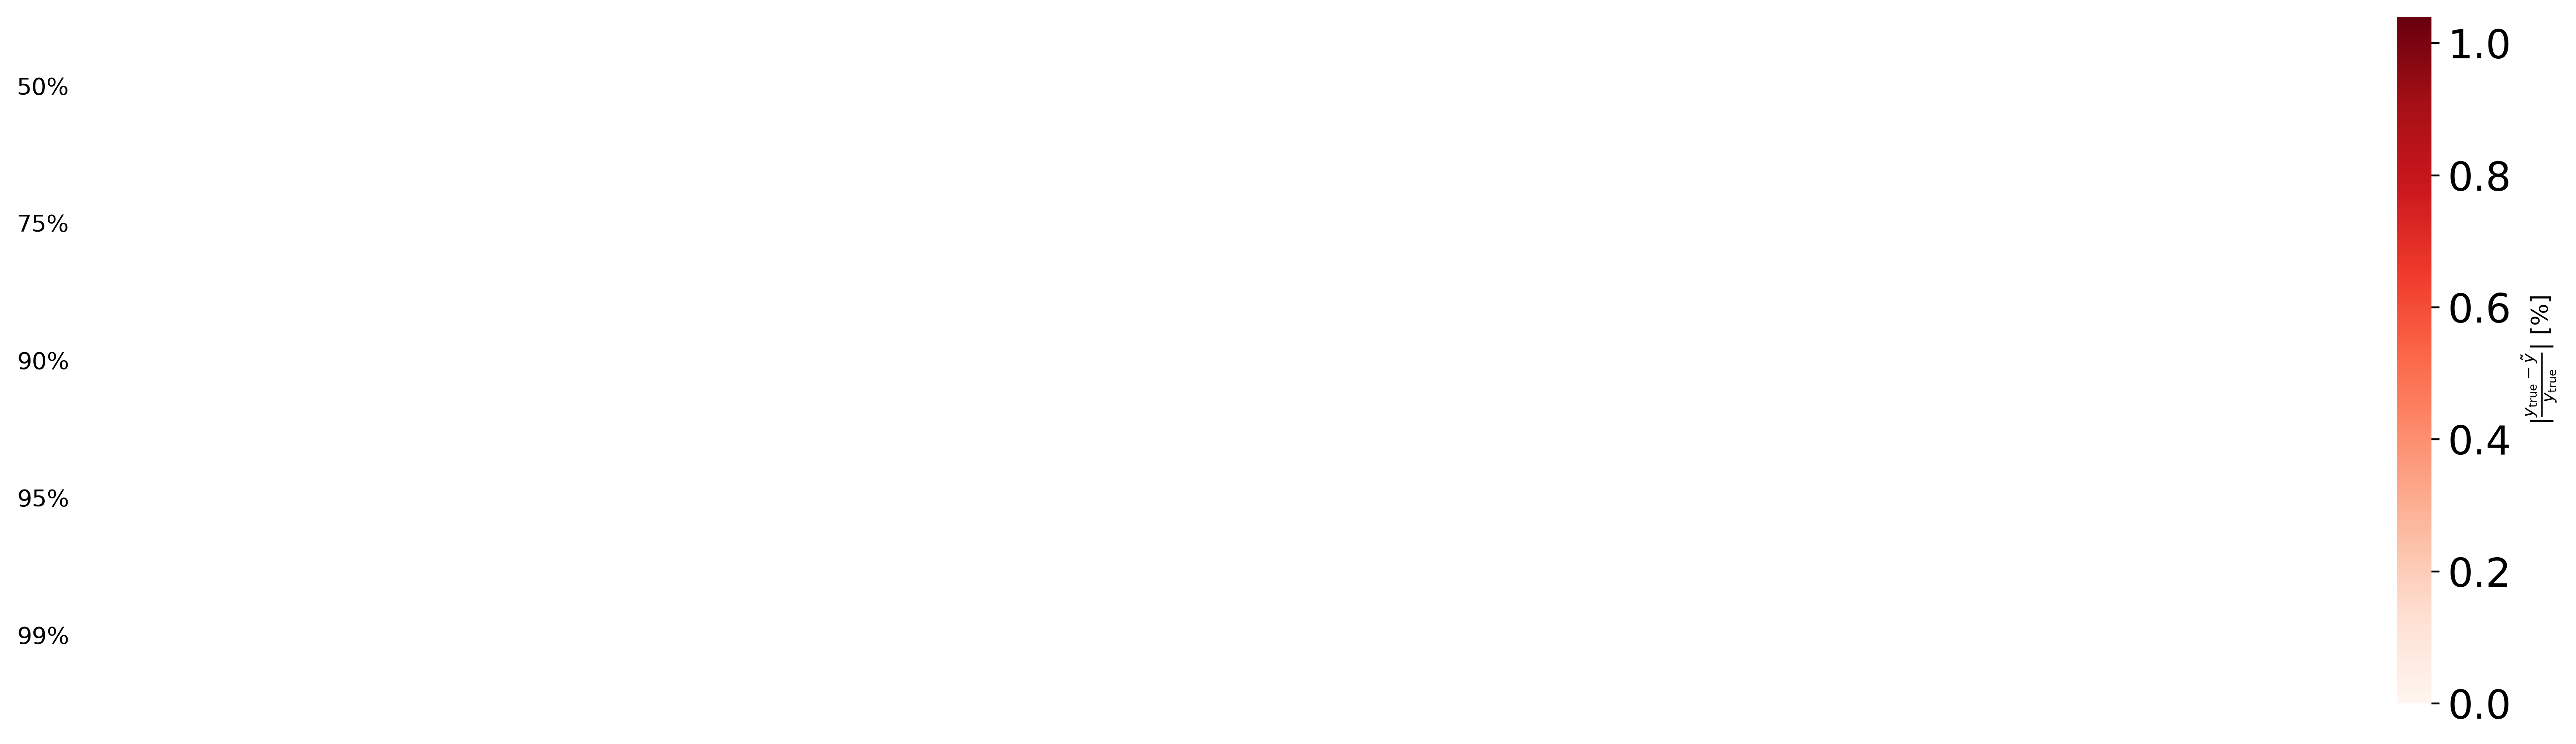

In [84]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_P12,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P12.jpg')

# Further plots
## DVARs vs. percentage errors

In [85]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [86]:
qoi_test.columns[0:11]

Index(['P11_0.532_5', 'P11_0.532_6', 'P11_0.532_7', 'P11_0.532_8',
       'P11_0.532_9', 'P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12',
       'P11_0.532_13', 'P11_0.532_14', 'P11_0.532_15'],
      dtype='object')

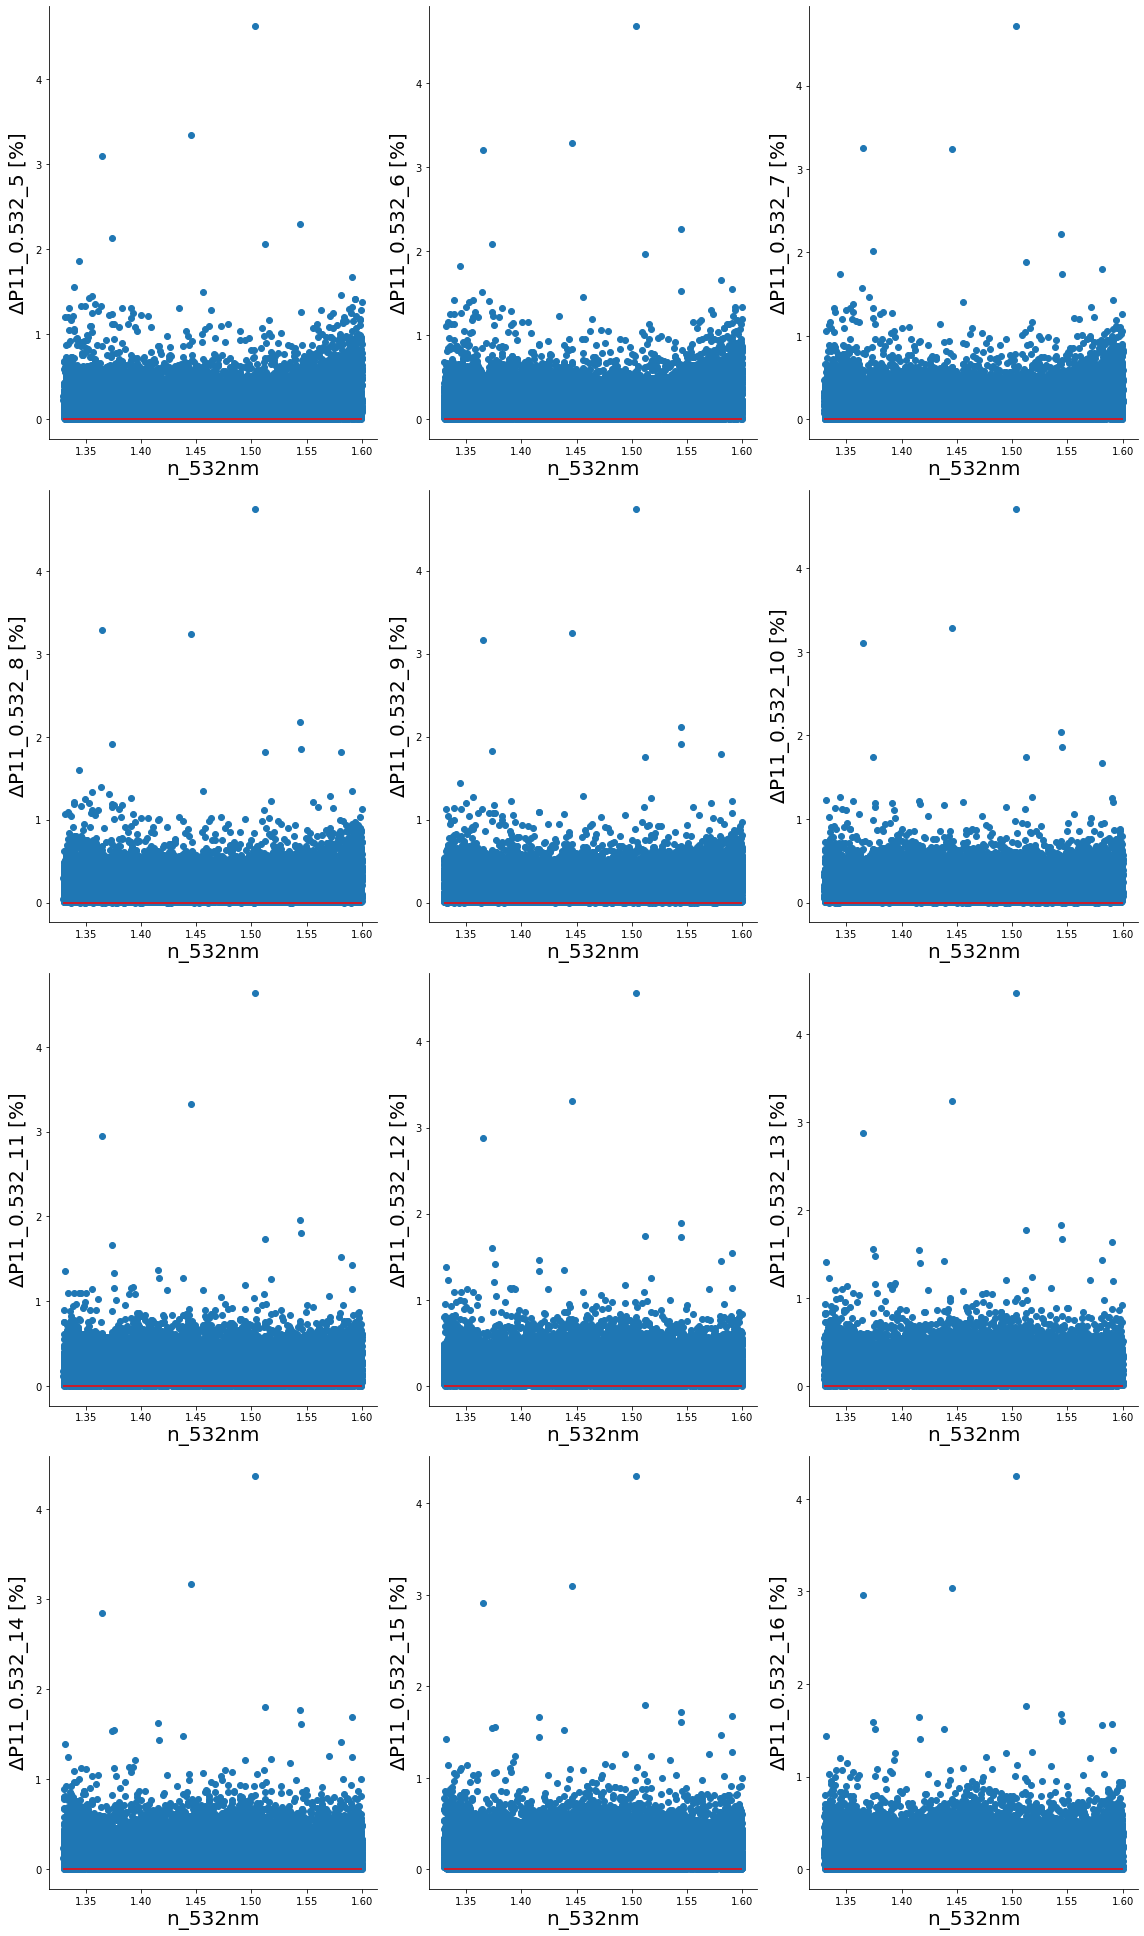

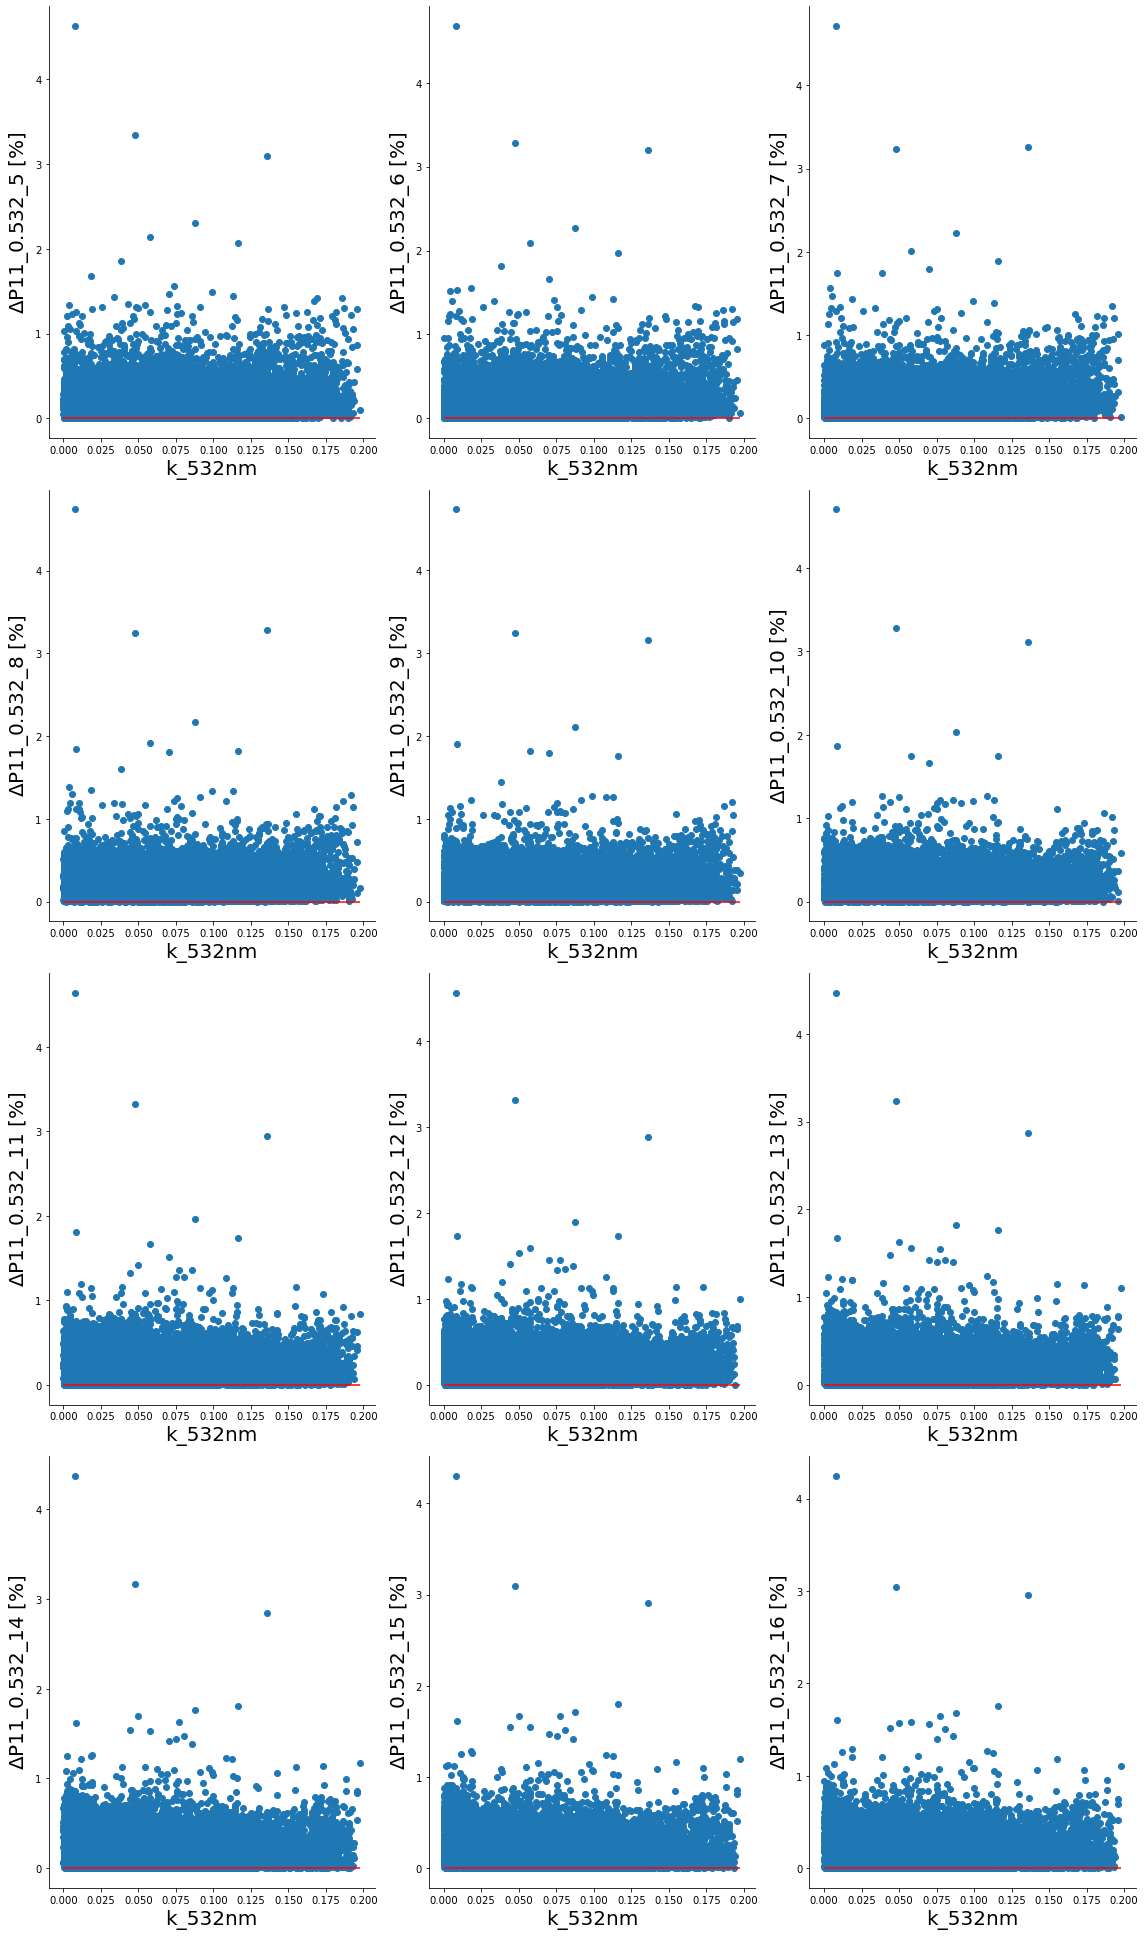

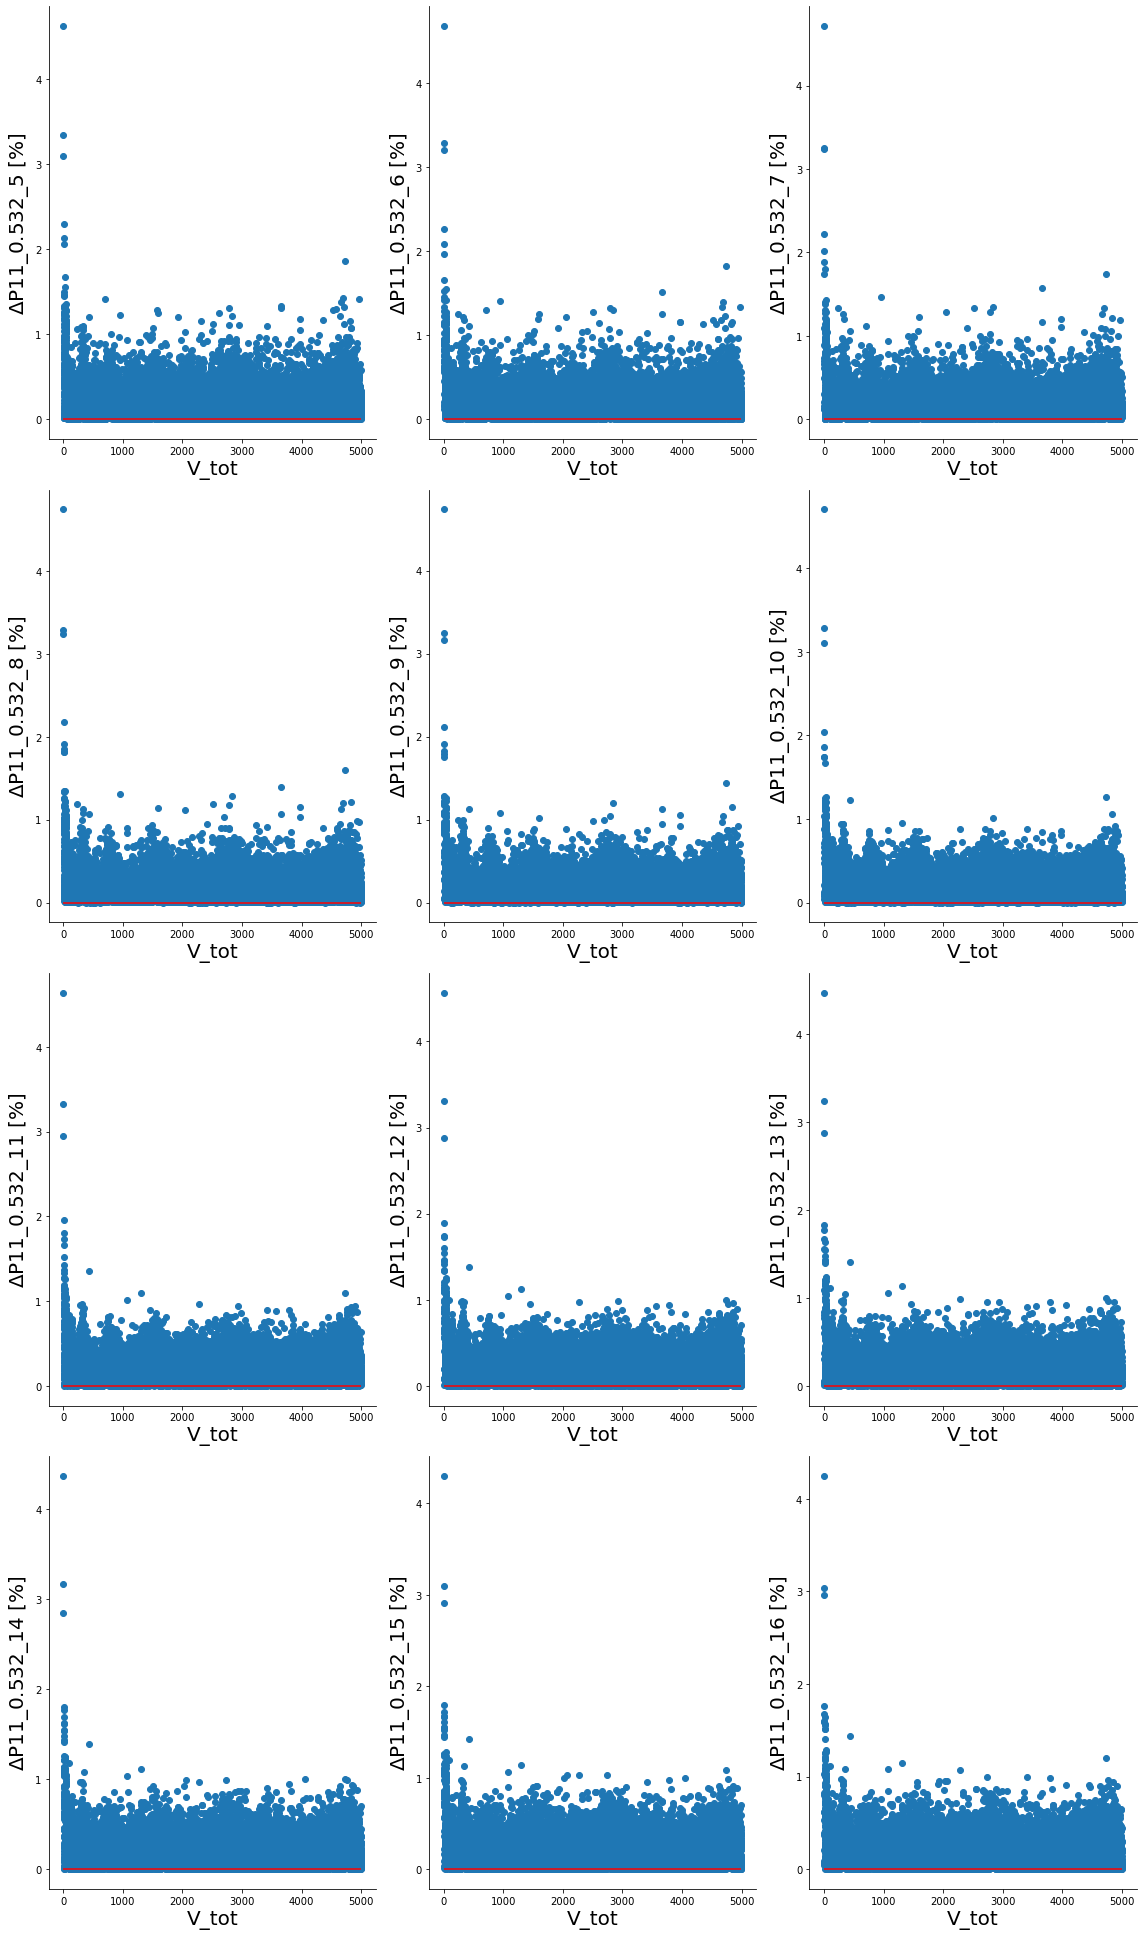

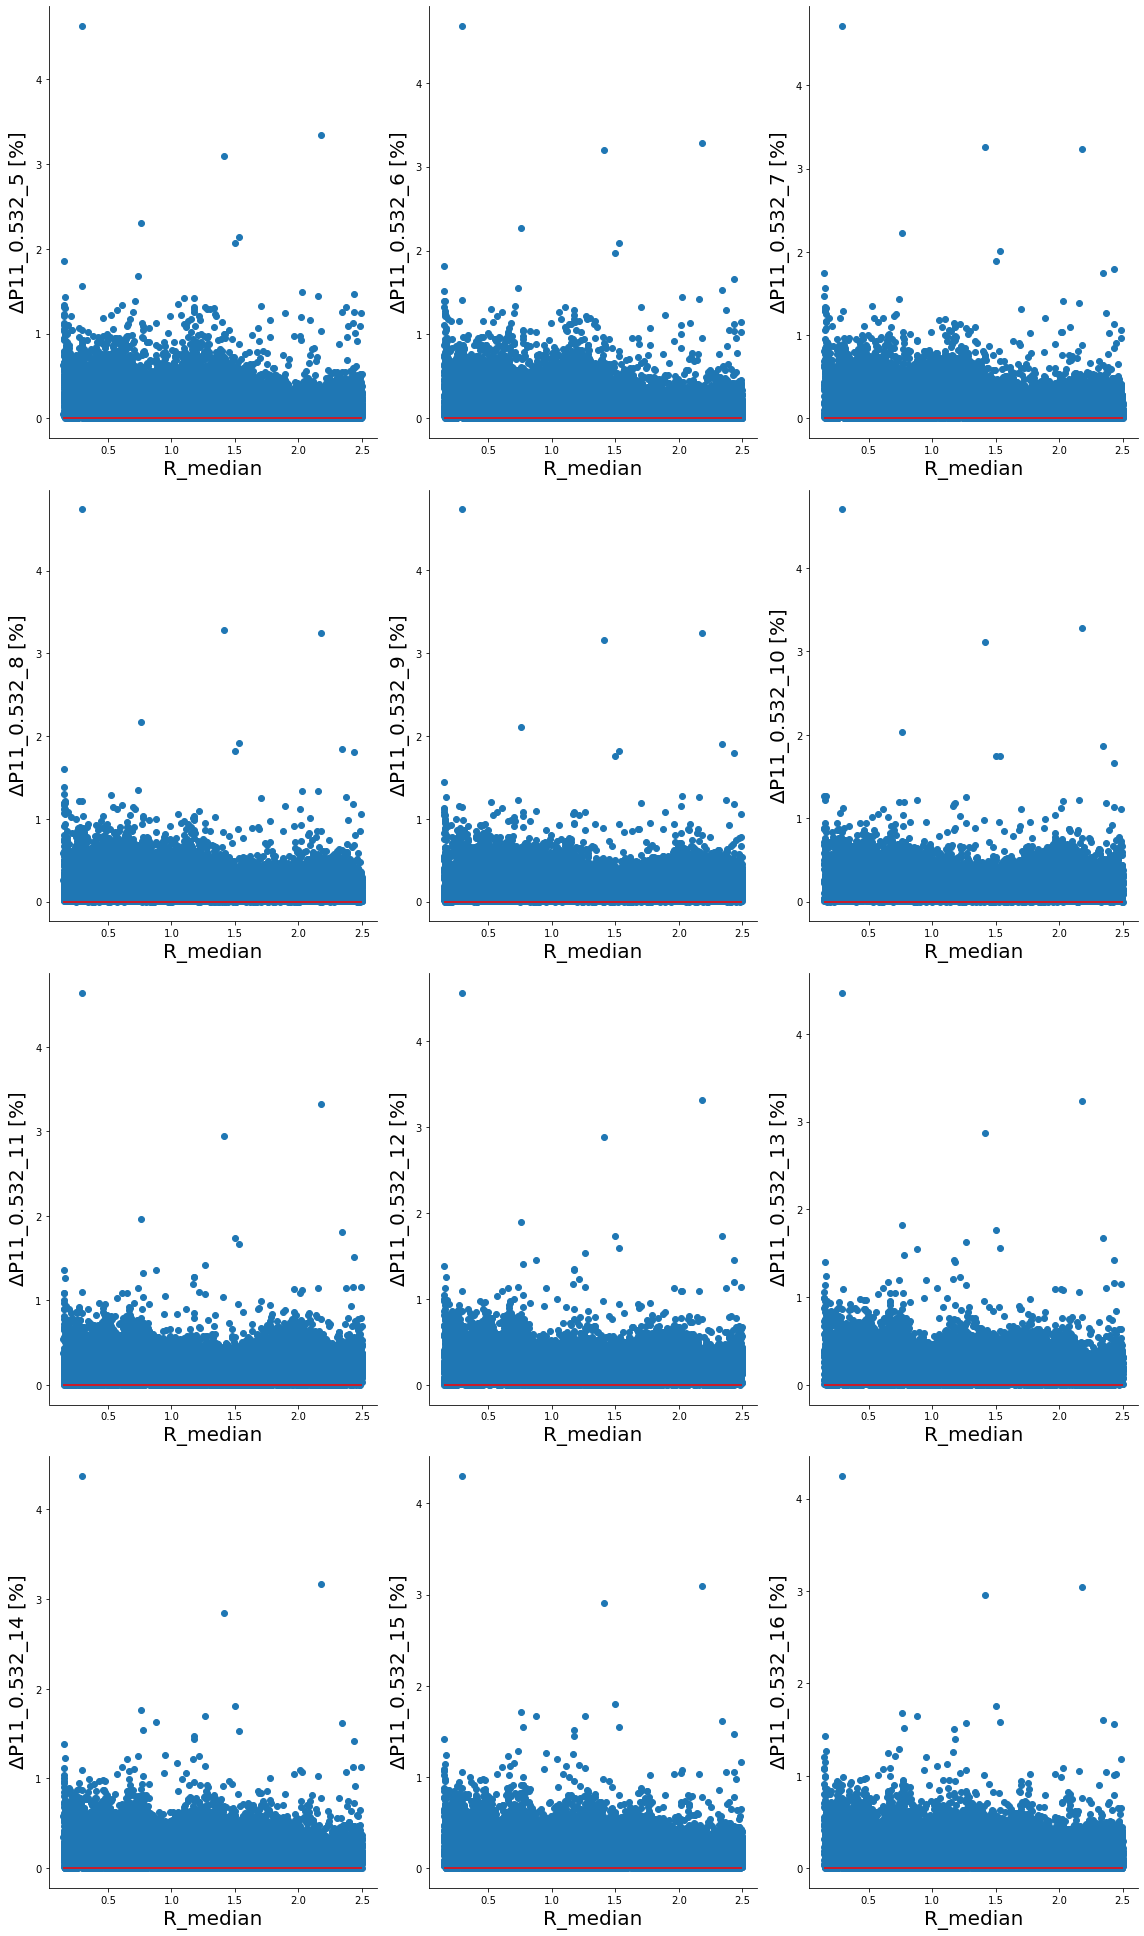

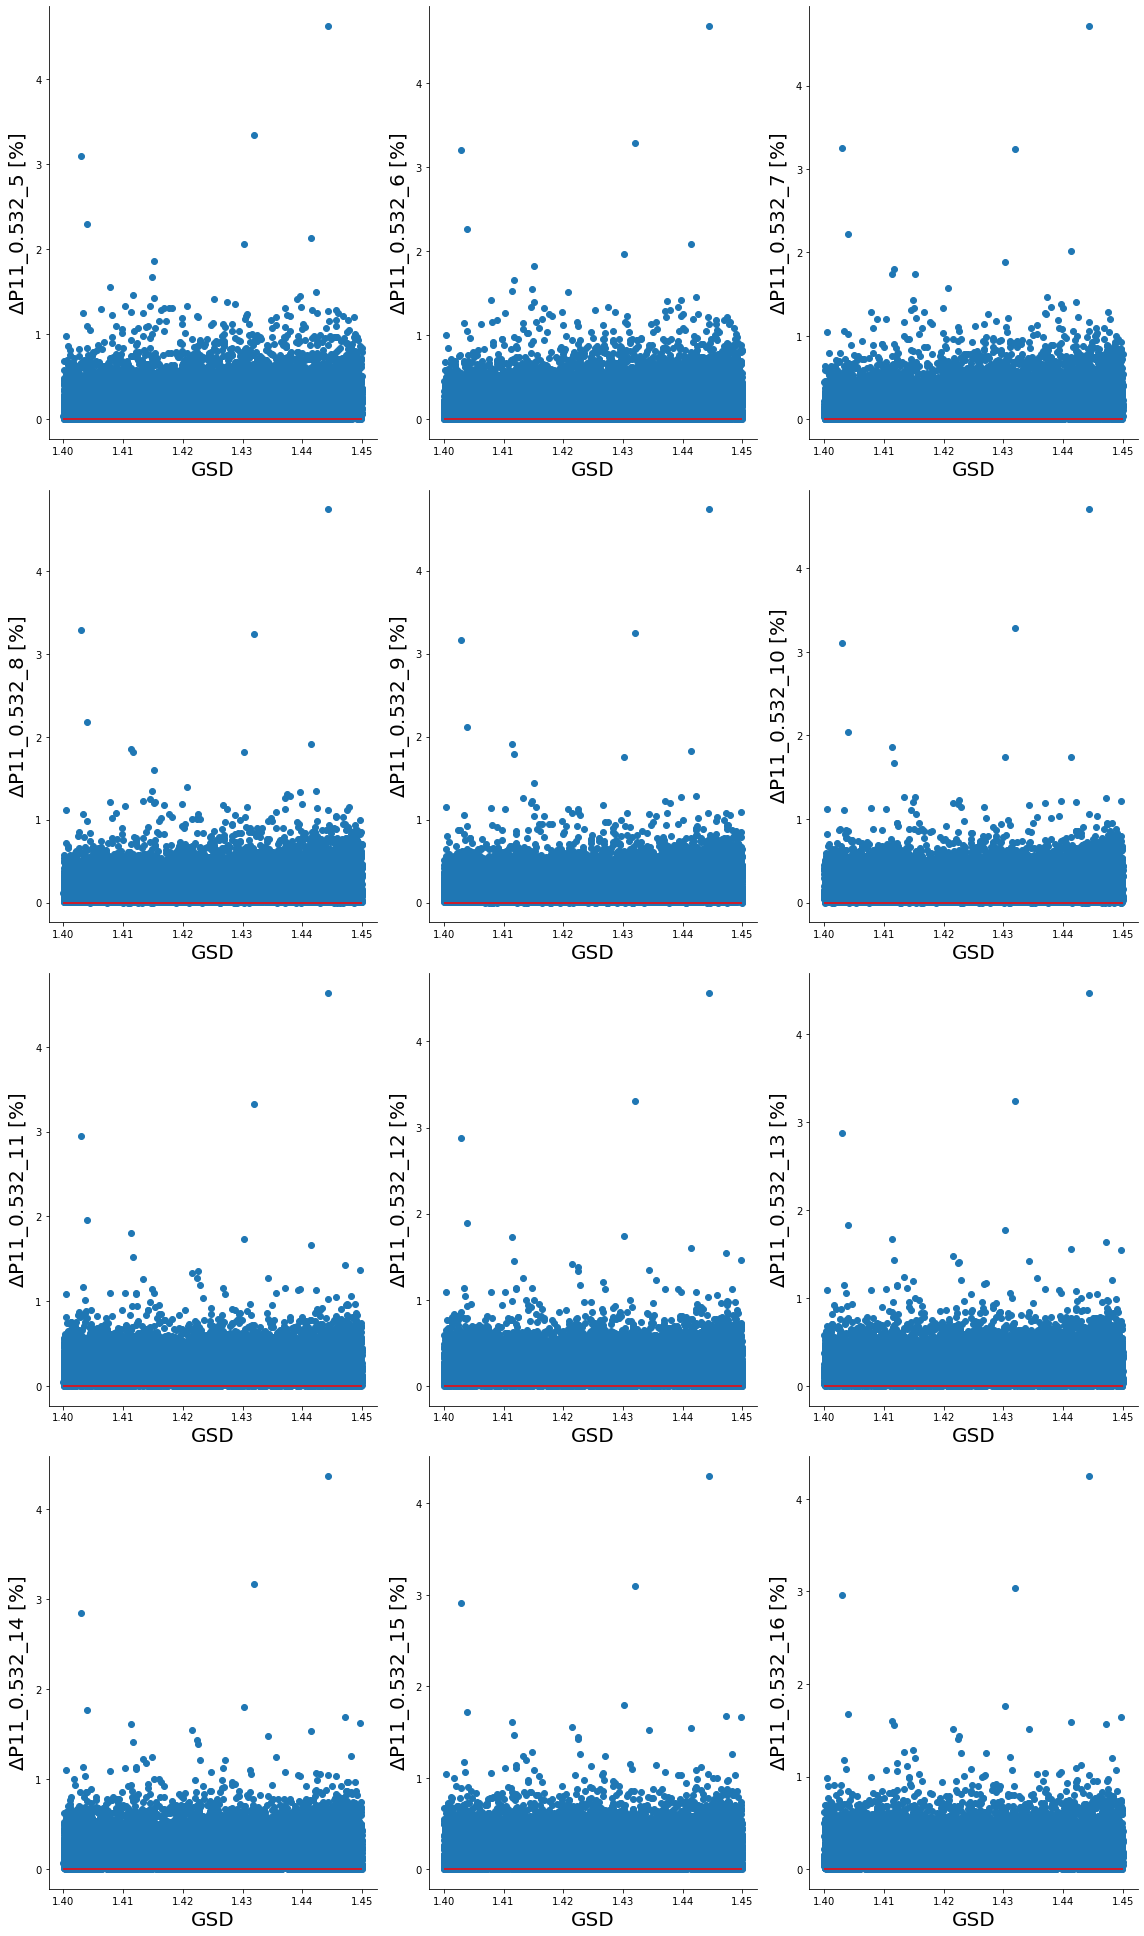

In [87]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

## Correlations between DVARs and QOIs

In [88]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [89]:
corr = np.round(combined.corr(), decimals=2)

In [98]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [100]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [101]:
to_plot

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
n_532nm          0.08         0.08         0.08         0.07         0.05   
k_532nm          0.09         0.10         0.11         0.09         0.06   
V_tot           -0.06        -0.05        -0.04        -0.04        -0.05   
R_median        -0.27        -0.27        -0.24        -0.18        -0.12   
GSD              0.14         0.16         0.15         0.13         0.09   

          P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
n_532nm           0.03         -0.00         -0.01         -0.03   
k_532nm           0.01         -0.01         -0.00          0.00   
V_tot            -0.05         -0.05         -0.05         -0.06   
R_median         -0.08         -0.06         -0.11         -0.16   
GSD               0.05         -0.00         -0.02         -0.02   

          P11_0.532_14  ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
n_532nm          -0.05  ...           0.03           0.02          -0.00   
k_532nm          -0.01  ...          -0.08          -0.10          -0.12   
V_tot            -0.05  ...          -0.02          -0.02          -0.02   
R_median         -0.20  ...          -0.07          -0.04          -0.02   
GSD              -0.01  ...           0.00          -0.01          -0.02   

          P11_0.532_169  P11_0.532_170  P11_0.532_171  P11_0.532_172  \
n_532nm           -0.02          -0.02           0.01           0.05   
k_532nm           -0.14          -0.15          -0.14          -0.12   
V_tot             -0.02          -0.03          -0.03          -0.03   
R_median          -0.03          -0.06          -0.10          -0.12   
GSD               -0.02          -0.02          -0.01          -0.01   

          P11_0.532_173  P11_0.532_174  P11_0.532_175  
n_532nm            0.09           0.12           0.17  
k_532nm           -0.10          -0.09          -0.09  
V_tot             -0.02          -0.01          -0.00  
R_median          -0.14          -0.15          -0.17  
GSD               -0.01          -0.01          -0.01  

[5 rows x 160 columns]

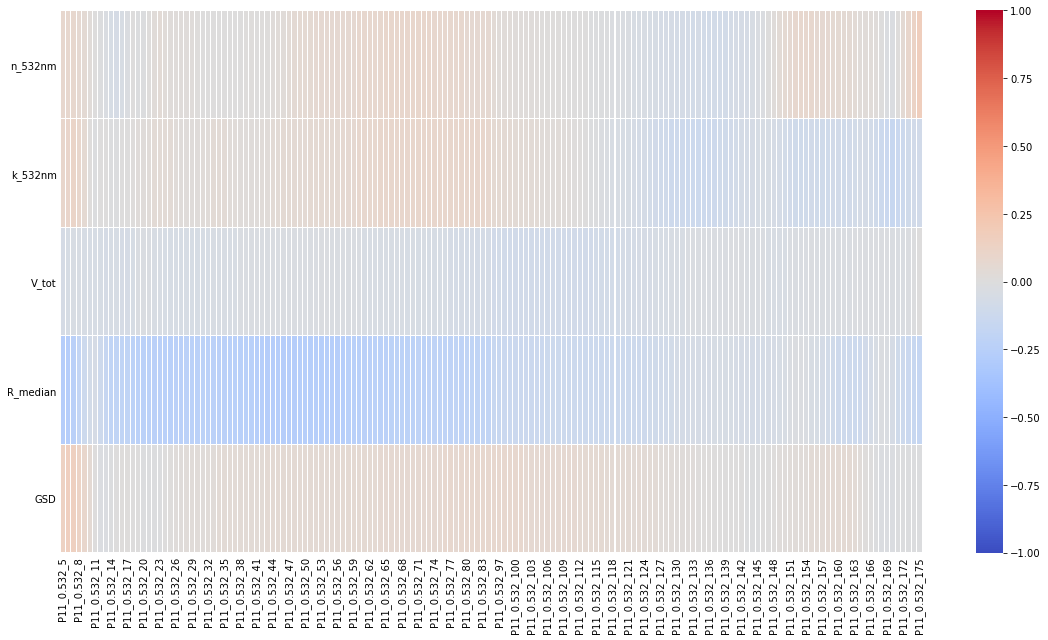

In [102]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

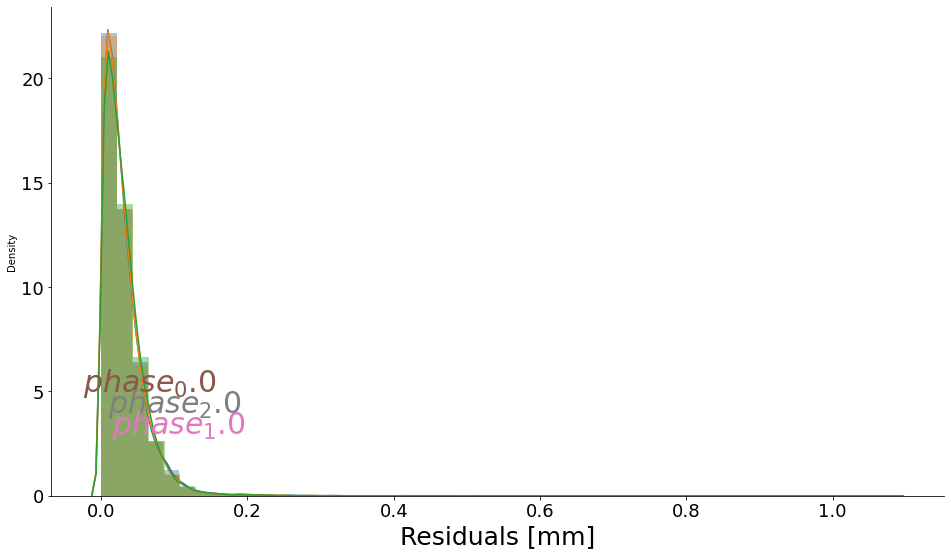

In [104]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(abs_error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[5],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[6],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[7],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [105]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [106]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

0
P11_0.532_5
1
P11_0.532_6
2
P11_0.532_7
3
P11_0.532_8
4
P11_0.532_9
5
P11_0.532_10
6
P11_0.532_11
7
P11_0.532_12
8
P11_0.532_13
9
P11_0.532_14
10
P11_0.532_15


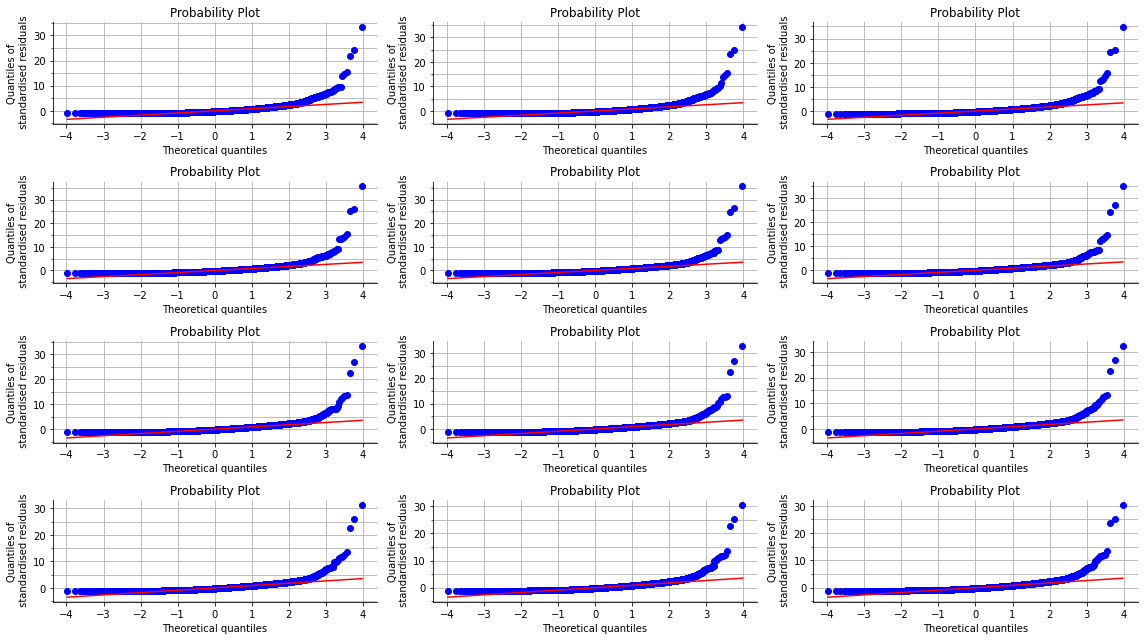

In [107]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(abs_error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [57]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [108]:
statistic, p = scipy.stats.shapiro(standardise(abs_error[qoi_test.columns[0]]).values)

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [109]:
statistic

0.7199735641479492

In [110]:
p

0.0

In [111]:
surr.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 160)               3360      
Total params: 4,320
Trainable params: 4,320
Non-trainable params: 0
_________________________________________________________________


In [114]:
from keras.utils.vis_utils import plot_model

In [115]:
plot_dir

'/data/user/boiger_r/aerosol/aerosol_results/simulated_data/forward_model12/plots/model'

In [116]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


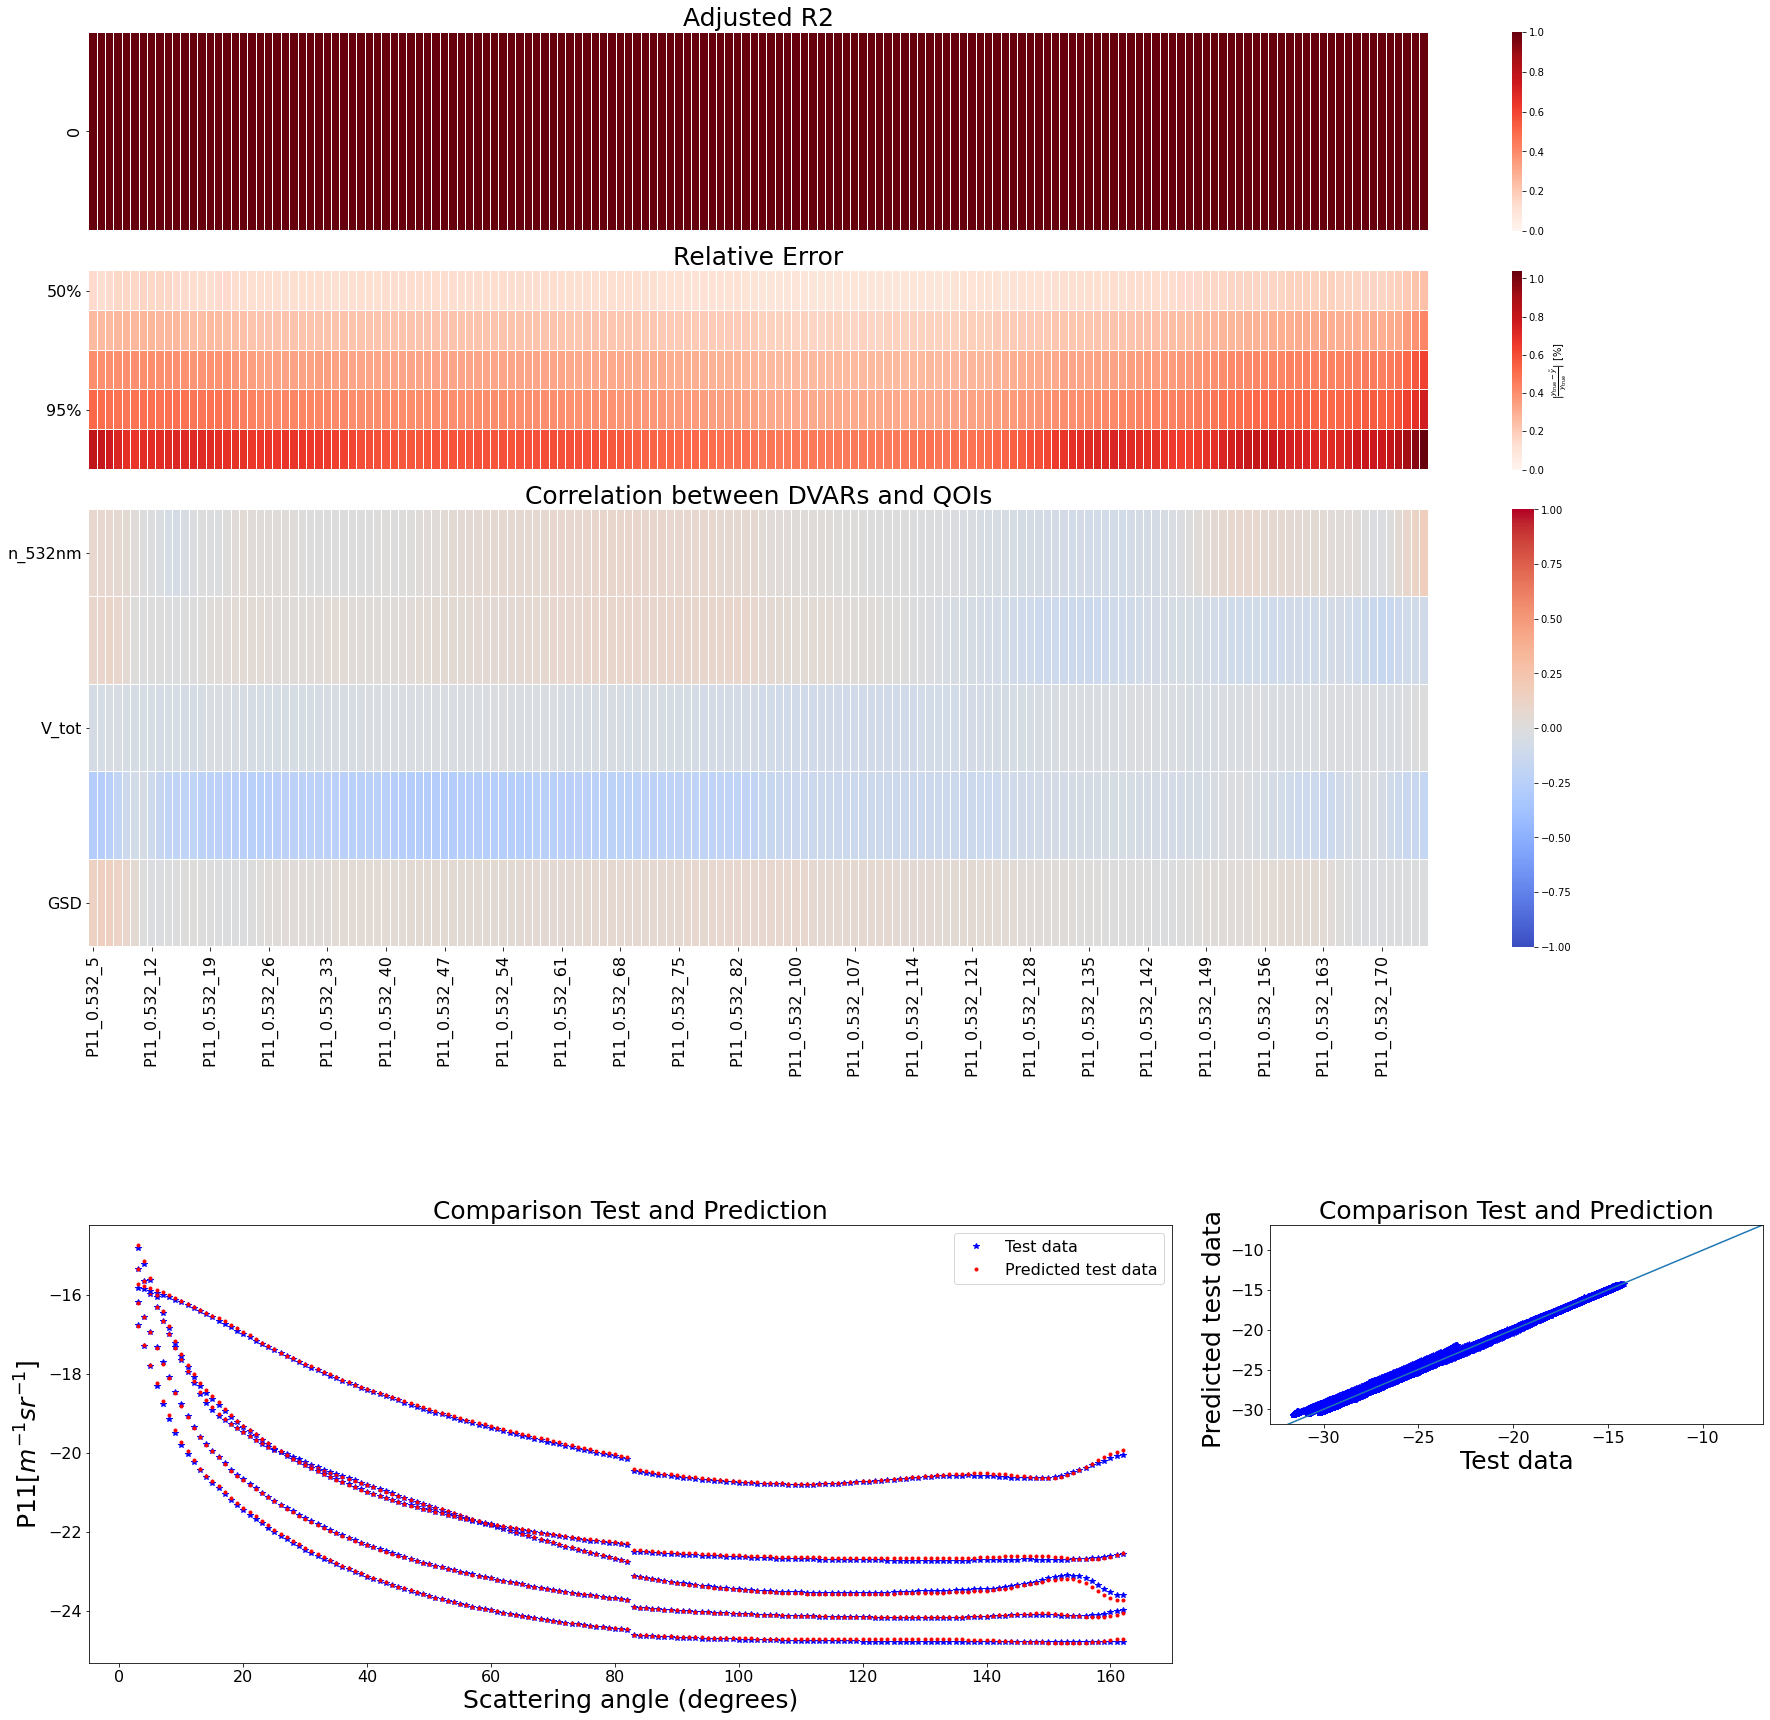

In [119]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')


# Store results

In [128]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

Index(['Unnamed: 0', 'MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val',
       'MSE_train', 'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'time_this_iter_s', 'done', 'timesteps_total',
       'episodes_total', 'training_iteration', 'experiment_id', 'date',
       'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id', 'experiment_tag',
       'config/batch_size', 'config/datafile', 'config/depth', 'config/lr',
       'config/width', 'logdir'],
      dtype='object')

In [117]:
store_results = pd.DataFrame()

In [130]:
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['abs_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)





store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

KeyError: 'config/preprocessor_x'

In [129]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/lr']

store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']

KeyError: 'config/learning_rate'

In [125]:
store_results

rel_error95%_qoi_P11_max  abs_error95%_qoi_P11_max  \
0                      0.76                      0.17   

   rel_error95%_qoi_P12_max  abs_error95%_qoi_P12_max  MAE_qoi_max  \
0                         0                         0     0.066191   

   MAPE%_qoi_max  explained_variance_qoi_min  
0       0.002976                    0.997857